# 汎用スクリプト　base
概要：このファイルは①データ読み込み、②可視化、③前処理、④分析までを型化し、汎用利用を考えたもの

活用方法：記載されているコードをベースにし、プロセスごとにコードを整理し、データサイエンスプロセスを効率化




## ⓪ライブラリ読み込み

In [1]:
#データ加工ライブラリ
import pandas as pd

#可視化ライブラリ
import matplotlib.pyplot as plt
import seaborn as sns

import numpy as np
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats
import warnings


## ①データ読み込み



## 進め方

■流れ
文字コードによって適切に読み込まれない場合がある場合は、以下の様に進める

①文字コードの特定(nkf)　②pandas.read_csvの引数指定

■文字コード

https://dev.classmethod.jp/tool/character-code-and-line-feed-code-converting-tools-matome/

■公式　pandas.read_csv

https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html



In [2]:
#csvファイルの読み込み
df_train=pd.read_csv('train.csv')
df_test=pd.read_csv('test.csv')

## ②可視化


セルを右クリックして、variable inspectorを利用すると、データの表を確認できる

より複雑な可視化をする場合は、BIツールで実施したほうが費用対効果高そう

Index(['Id', 'MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig',
       'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType',
       'HouseStyle', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd',
       'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType',
       'MasVnrArea', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual',
       'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1',
       'BsmtFinType2', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating',
       'HeatingQC', 'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF',
       'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath',
       'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual',
       'TotRmsAbvGrd', 'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType',
       'GarageYrBlt', 'GarageFinish', 'GarageCars', 'GarageArea', 'GarageQual',
       'GarageCond', 'PavedDrive

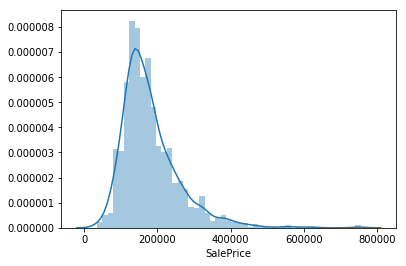

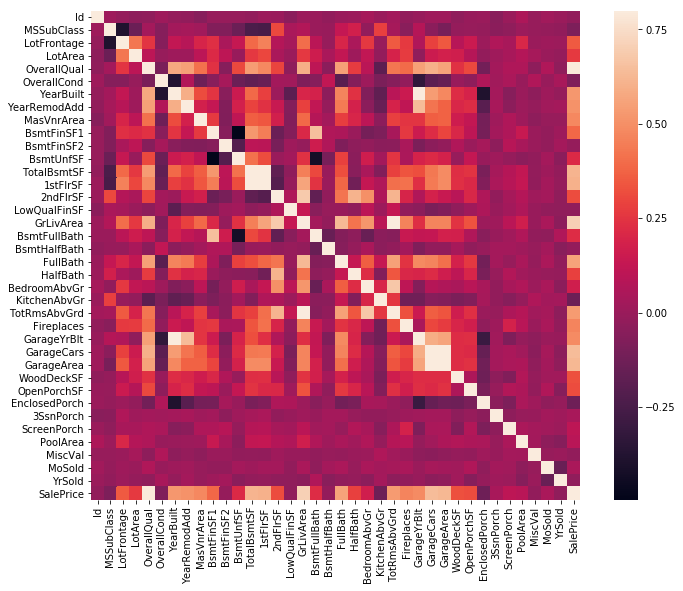

In [3]:
#列名の確認
print(df_train.columns)
print("-----------------------")

#目的変数の基本統計量確認
print(df_train['SalePrice'].describe())
print("-----------------------")

#目的変数をヒストグラムでの可視化
sns.distplot(df_train['SalePrice'])
plt.show()



#相関ヒートマップ
corrmat=df_train.corr()
f,ax=plt.subplots(figsize=(12,9))
sns.heatmap(corrmat,vmax=0.8,square=True)
plt.show()

## ③前処理
各変数において必要な処理は以下のようになる。（個人的な理解）特徴量エンジニアリングの世界なので、まだ完全に定石手法を理解しきれていない、

①特徴選択

②特徴データに対する欠損対応

③適切なデータ変換(量⇛質　質⇛量)

③説明変数に対して、正規化対応

## 特徴選択

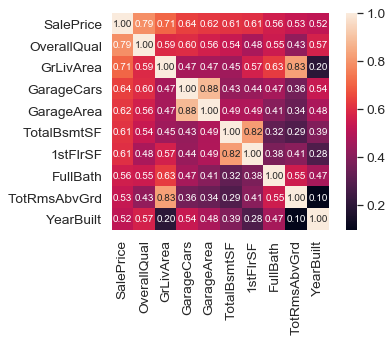

In [4]:
#目的変数と説明変数の相関高TOP10
#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index

cm = np.corrcoef(df_train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

### 特徴量選択のロジック

まず'OverallQual','GrLivArea','TotalBsmtSF'は'SalePrice'への相関が高い。
　⇛特徴量に入れよう

'GarageCars' と'GarageArea'は目的変数に対して、相関が強い変数ではあるが、ガレージに入る車の数はガレージの広さの結果によるものであるので、多重共線性があるといえる。
　⇛どちらか一つを選択する必要があるので、目的変数への相関が強い'GarageCars'を選択する
 
'TotalBsmtSF' と'1stFloor'も多重共線性がありそう、'TotalBsmtSF'を残す。

'TotRmsAbvGrd' と'GrLivArea'も多重共線性がありそう



In [11]:
#特徴量選択
feature_column=['OverallQual', 'GarageCars', 'TotalBsmtSF', 'YearBuilt']

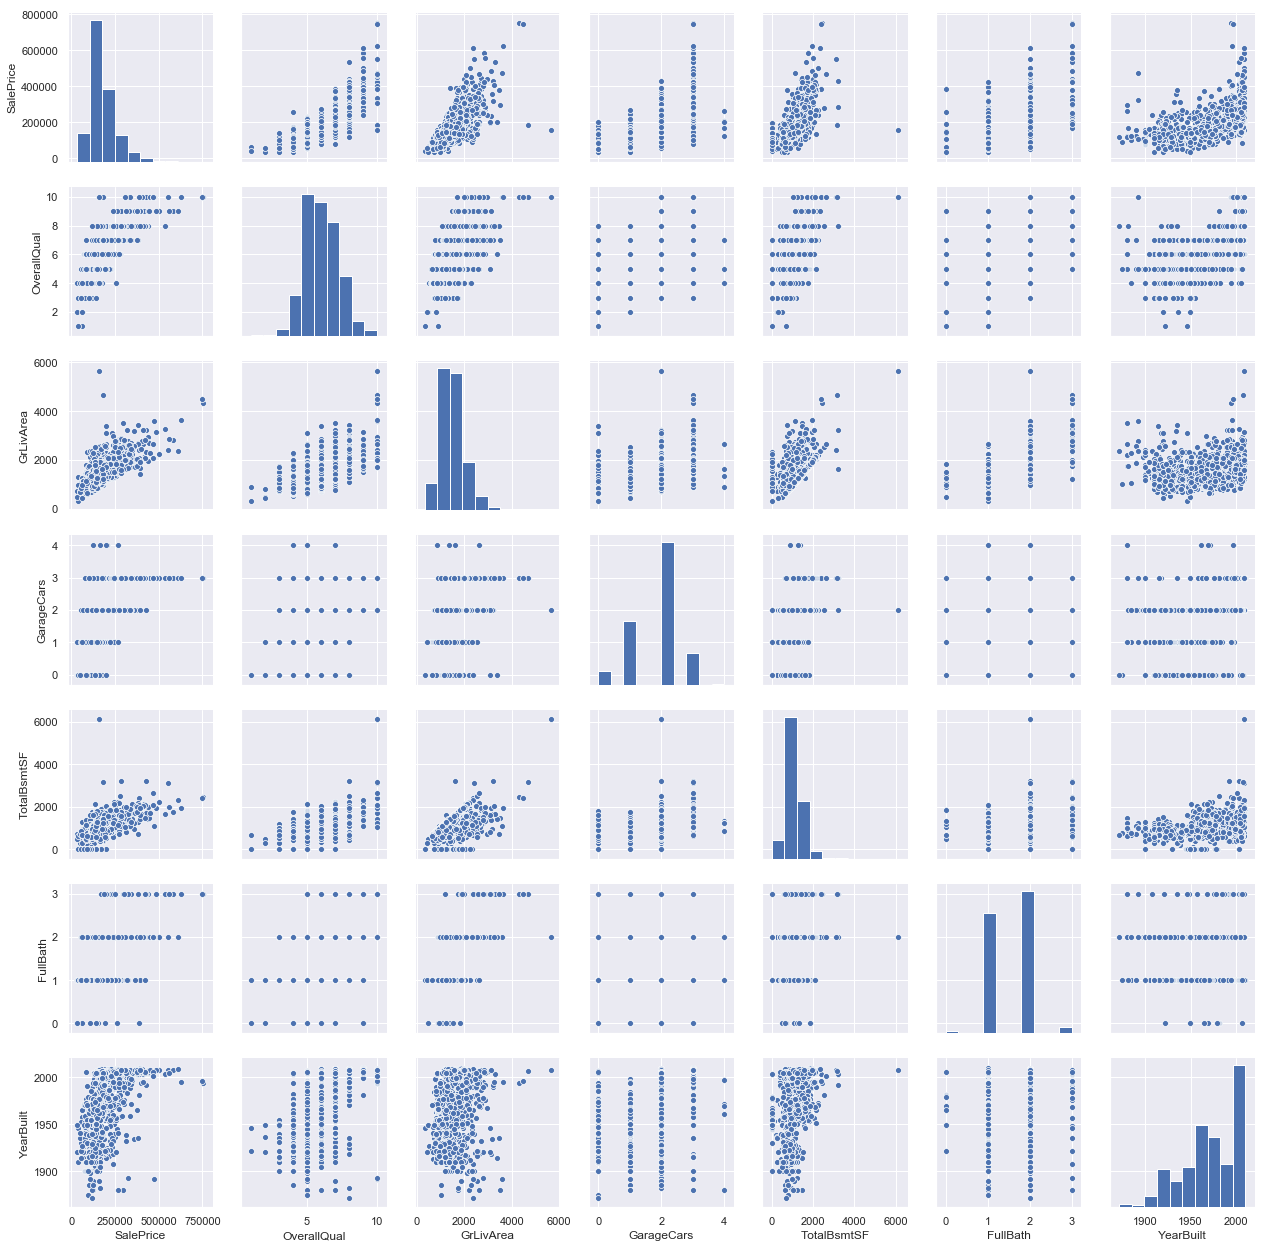

In [6]:
#散布図による確認
sns.set()
cols=['SalePrice','OverallQual','GrLivArea','GarageCars','TotalBsmtSF','FullBath','YearBuilt']
sns.pairplot(df_train[cols],height=2.5)
plt.show()


## 欠損対応

In [7]:
#欠損値の確認
total=df_train.isnull().sum().sort_values(ascending=False)
percent=(df_train.isnull().sum()/df_train.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])

#欠損値があるデータを消す
df_train=df_train.drop((missing_data[missing_data['Total']>1]).index,1)
df_train.drop(df_train.loc[df_train['Electrical'].isnull()].index)
df_train.isnull().sum().max()

1

## 外れ値対応

outer range (low) of the distribution
[[-1.83870376]
 [-1.83352844]
 [-1.80092766]
 [-1.78329881]
 [-1.77448439]
 [-1.62337999]
 [-1.61708398]
 [-1.58560389]
 [-1.58560389]
 [-1.5731    ]]

 outer range (high) pf the destribution
[[3.82897043]
 [4.04098249]
 [4.49634819]
 [4.71041276]
 [4.73032076]
 [5.06214602]
 [5.42383959]
 [5.59185509]
 [7.10289909]
 [7.22881942]]


'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


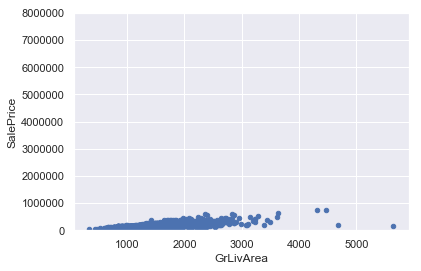

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.


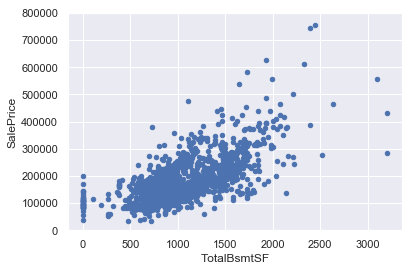

In [8]:
#外れ値対応

saleprice_scaled=StandardScaler().fit_transform(df_train['SalePrice'][:,np.newaxis])
low_range=saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range=saleprice_scaled[saleprice_scaled[:,0].argsort()[-10:]]
print("outer range (low) of the distribution")
print(low_range)
print("\n outer range (high) pf the destribution")
print(high_range)

var='GrLivArea'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,8000000))
plt.show()

#外れ値を削除

df_train.sort_values(by='GrLivArea',ascending=False)[:2]
df_train=df_train.drop(df_train[df_train['Id']==1299].index)
df_train=df_train.drop(df_train[df_train['Id']==524].index)

var='TotalBsmtSF'
data=pd.concat([df_train['SalePrice'],df_train[var]],axis=1)
data.plot.scatter(x=var,y='SalePrice',ylim=(0,800000))
plt.show()

## データ確認

正規性

分散均一性

線形性

誤差相関







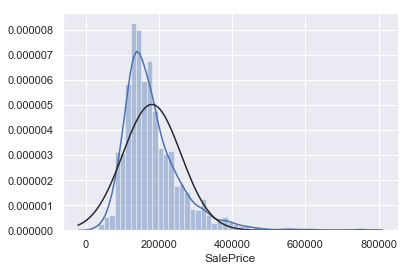

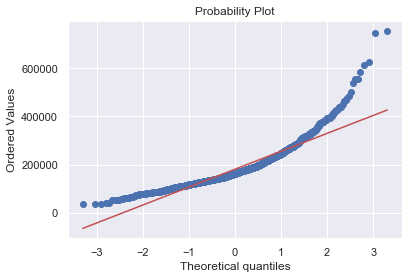

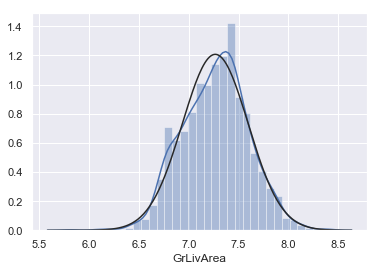

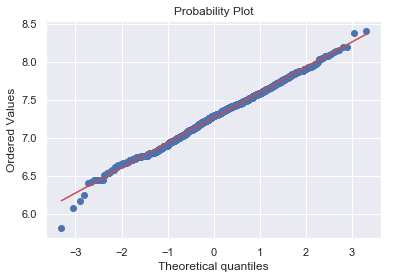

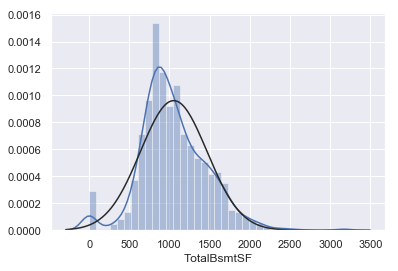

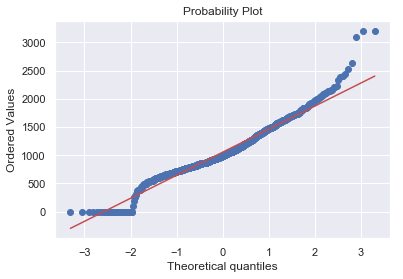

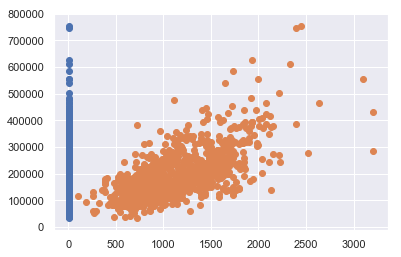

In [9]:
#ヒストグラムと正規確率分布
sns.distplot(df_train['SalePrice'],fit=norm)
fig=plt.figure()
res=stats.probplot(df_train['SalePrice'],plot=plt)
plt.show()

#データ変形
df_train['GrLivArea']=np.log(df_train['GrLivArea'])

#変形後のヒストグラムと正規確率分布
sns.distplot(df_train['GrLivArea'],fit=norm)
fig=plt.figure()
res=stats.probplot(df_train['GrLivArea'],plot=plt)
plt.show()

#histogram and normal probability plot
sns.distplot(df_train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(df_train['TotalBsmtSF'], plot=plt)
plt.show()

#散布図
plt.scatter(df_train['GrLivArea'],df_train['SalePrice'])

plt.scatter(df_train[df_train['TotalBsmtSF']>0]['TotalBsmtSF'],df_train[df_train['TotalBsmtSF']>0]['SalePrice'])

df_train=pd.get_dummies(df_train)

## ④データ分析